### Evaluation of Faster-RCNN FPN with and without Tracktor

The model has been trained on 25K reviewed images from Faxe. The test set are the 3 roads: _Hylleholtvej_, _Bækvej_ and _Strandvejen_ which the model has any images of during training.

In [1]:
%matplotlib inline
import os
import sys
from tqdm.notebook import tqdm
import torch

import copy
import os
import time
from os import path as osp

sys.path.insert(0, os.path.abspath('../../'))
import numpy as np
import sacred
import torch
import yaml
from sacred import Experiment
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from tracktor.config import get_output_dir
from tracktor.datasets.factory import Datasets
from tracktor.datasets.custom_wrapper import CustomSequence
from tracktor.frcnn_fpn import FRCNN_FPN
from tracktor.oracle_tracker import OracleTracker
from tracktor.reid.resnet import ReIDNetwork_resnet50
from tracktor.tracker import Tracker
from tracktor.utils import (evaluate_mot_accums, get_mot_accum,
                            interpolate_tracks, plot_sequence)

sys.path.insert(0, os.path.abspath('../../src/faster_rcnn_fpn'))

In [2]:
# Get through `make metrics`:
sys.path.append(os.path.abspath('../../metrics'))
import src.evaluators.pascal_voc_evaluator as pascal_voc_evaluator
import src.utils.converter as converter
from src.utils.enumerators import BBFormat, BBType, MethodAveragePrecision

In [3]:
from engine import train_one_epoch, evaluate
import utils

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [4]:
from google.cloud import storage
PROJECT_NAME = "pluto-a31d9"
BUCKET_NAME = "pluto-tracking-samples"
client = storage.Client(project=PROJECT_NAME)
bucket = client.get_bucket(BUCKET_NAME)

groundtruth = bucket.get_blob("3_roads_faxe_gt_annotations.csv")
model_output = bucket.get_blob("3_roads_faxe_model_output.csv")

In [32]:
import csv
import pandas as pd
from io import StringIO, BytesIO
annotations_df = pd.read_csv(StringIO(groundtruth.download_as_string().decode("utf-8")))

# Image id is in model output file:
model_output_df = pd.read_csv(StringIO(model_output.download_as_string().decode("utf-8")))

annotations_df = annotations_df.merge(
    model_output_df[['image', 'image_id']].drop_duplicates(['image_id']),
    on='image_id'
)

# "CaptureId" column is expected, we can use the`image_id` as "proxy":
annotations_df["CaptureId"] = annotations_df['image_id']

img_ids = []
img_paths = []
for i, row in annotations_df.drop_duplicates(['image_id'], keep='first').iterrows():
    capture_id = row.image_id
    img_paths.append(f"testdata/images/{row.image}")
    img_ids.append(capture_id)

In [26]:
annotations_df = pd.read_csv(StringIO(groundtruth.download_as_string().decode("utf-8")))

In [33]:
annotations_df.head(10)

,image_id,ClassName,Confidence,X1,X2,Y1,Y2,AnnotationId,label,image,CaptureId
0,e4e81487-8128-40c4-a6e2-bd693e4eeba4,13,0.40625,1,146,653,795,7106da40-9e87-4d08-bfdc-f93104f040ab,R30,0001_e4e81487-8128-40c4-a6e2-bd693e4eeba4_img,e4e81487-8128-40c4-a6e2-bd693e4eeba4
1,e45d6a0b-5e68-43f7-9df0-eb6d302bb1a8,13,1.00000,2,246,666,862,c2a95d03-fb5d-44a0-a68f-228aabe35456,R30,0040_e45d6a0b-5e68-43f7-9df0-eb6d302bb1a8_img,e45d6a0b-5e68-43f7-9df0-eb6d302bb1a8
2,732f21b0-c7b8-4165-aecc-bce391eb4c7f,13,1.00000,2,285,680,890,669a03bd-92f9-46ec-ab91-2967488c50fe,R30,0066_732f21b0-c7b8-4165-aecc-bce391eb4c7f_img,732f21b0-c7b8-4165-aecc-bce391eb4c7f
3,c9a141e6-9830-4f62-b39b-cc298aea4ecd,17,1.00000,110,177,714,733,ceefc4ac-bb7c-4bf8-9842-0de8ff97dacc,M10,0094_c9a141e6-9830-4f62-b39b-cc298aea4ecd_img,c9a141e6-9830-4f62-b39b-cc298aea4ecd
4,c9a141e6-9830-4f62-b39b-cc298aea4ecd,13,0.50000,1,279,723,928,a59fa0e5-2129-4d05-bf18-fa11b1231373,R30,0094_c9a141e6-9830-4f62-b39b-cc298aea4ecd_img,c9a141e6-9830-4f62-b39b-cc298aea4ecd
5,b8ee6871-3f4c-4c6a-9204-9fc91e920206,18,1.00000,791,846,812,828,48eaf233-5a1c-40e3-af92-7b5d4bccc0ca,M20,0117_b8ee6871-3f4c-4c6a-9204-9fc91e920206_img,b8ee6871-3f4c-4c6a-9204-9fc91e920206
6,b8ee6871-3f4c-4c6a-9204-9fc91e920206,10,1.00000,210,298,800,816,d2ef5196-0519-4d69-8fd4-aac39ae8126a,D10,0117_b8ee6871-3f4c-4c6a-9204-9fc91e920206_img,b8ee6871-3f4c-4c6a-9204-9fc91e920206
7,b8ee6871-3f4c-4c6a-9204-9fc91e920206,13,0.50000,0,320,709,958,5d44aebc-e6f5-4ced-bc4b-08395fd24e62,R30,0117_b8ee6871-3f4c-4c6a-9204-9fc91e920206_img,b8ee6871-3f4c-4c6a-9204-9fc91e920206
8,a81e6bbf-d62f-42b9-8736-af1d98b4bedf,13,0.50000,0,220,792,970,09dd9943-973f-4721-bbc4-e9b59ee5e0fa,R30,0139_a81e6bbf-d62f-42b9-8736-af1d98b4bedf_img,a81e6bbf-d62f-42b9-8736-af1d98b4bedf
9,a81e6bbf-d62f-42b9-8736-af1d98b4bedf,10,1.00000,231,349,704,788,e800556e-7122-4f9f-bc73-772898375f86,D10,0139_a81e6bbf-d62f-42b9-8736-af1d98b4bedf_img,a81e6bbf-d62f-42b9-8736-af1d98b4bedf


In [35]:
annotations_df[annotations_df['image_id'] == "b8ee6871-3f4c-4c6a-9204-9fc91e920206"]

,image_id,ClassName,Confidence,X1,X2,Y1,Y2,AnnotationId,label,image,CaptureId
5,b8ee6871-3f4c-4c6a-9204-9fc91e920206,18,1.0,791,846,812,828,48eaf233-5a1c-40e3-af92-7b5d4bccc0ca,M20,0117_b8ee6871-3f4c-4c6a-9204-9fc91e920206_img,b8ee6871-3f4c-4c6a-9204-9fc91e920206
6,b8ee6871-3f4c-4c6a-9204-9fc91e920206,10,1.0,210,298,800,816,d2ef5196-0519-4d69-8fd4-aac39ae8126a,D10,0117_b8ee6871-3f4c-4c6a-9204-9fc91e920206_img,b8ee6871-3f4c-4c6a-9204-9fc91e920206
7,b8ee6871-3f4c-4c6a-9204-9fc91e920206,13,0.5,0,320,709,958,5d44aebc-e6f5-4ced-bc4b-08395fd24e62,R30,0117_b8ee6871-3f4c-4c6a-9204-9fc91e920206_img,b8ee6871-3f4c-4c6a-9204-9fc91e920206


In [36]:
from tracktor.utils import classes as model_labels
from custom_data import PlutoObjectDetect
import transforms as T


dataset_no_random = PlutoObjectDetect(
    img_ids, img_paths, annotations_df, bucket,
    #osp.join(data_root_dir, 'train'),
    get_transform(train=False))

In [37]:
from tracktor.frcnn_fpn import FRCNN_FPN

obj_detects = []
obj_detect_model = "../../output/custom/model_epoch_30.model"
model = FRCNN_FPN(num_classes=31)
model.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(model)
model.eval()
model.cuda();

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Displaying image from the test set
Selecting and displaying the first image with more than 5 different labels from the test set

Finding the first image of 483 that has more than 5 labels to display variety


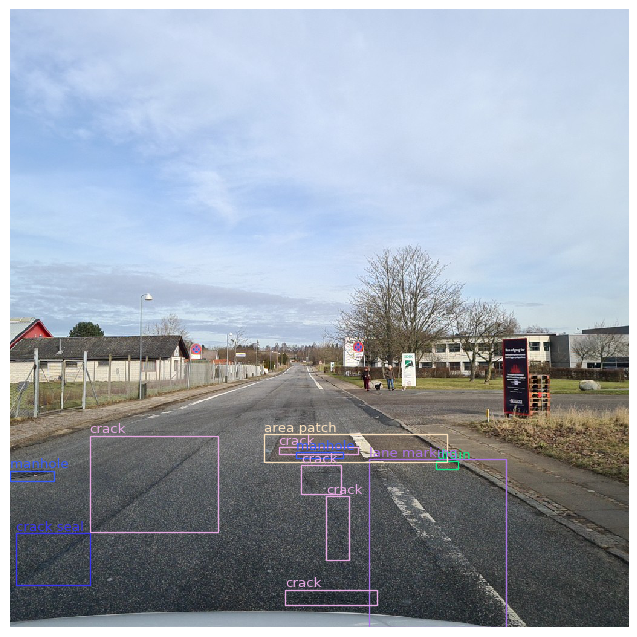

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
import transforms as T
from tracktor.utils import classes, class_index, rand_cmap

colors = rand_cmap(nlabels=len(annotations_df['ClassName'].unique()),
                   type='bright',
                   first_color_black=False)

def plot(img, boxes, labels):
    fig, ax = plt.subplots(1, dpi=96)
    
    img = img.mul(255).permute(1, 2, 0).byte().numpy()
    width, height, _ = img.shape

    ax.imshow(img, cmap=colors) #cmap='gray')
    #fig.set_size_inches(width / 80, height / 80)
    fig.set_size_inches(width / 120, height / 120)
    for label, box in zip(labels, boxes):
        #color = 1
        rect = plt.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            fill=False,
            linewidth=1.0,
            color=colors(label))
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 5, classes[class_index[str(label)]], color=colors(label))
        
    plt.axis('off')
    plt.show()

#dataset = PlutoObjectDetect(osp.join(data_root_dir, 'train'), split_seqs=['MOT17-09'])
dataset = PlutoObjectDetect(img_ids, img_paths, annotations_df, bucket)
num_labels = 5
print(f"Finding the first image of {len(dataset)} that has more than {num_labels} labels to display variety")
index = 0
for img, target in tqdm(dataset):
    if len(set(target['labels'].numpy())) > num_labels: break
    index += 1
        
#img, target = dataset[-15] #-5
img, target = T.ToTensor()(img, target)
plot(img, target['boxes'], target['labels'].numpy())

Showing the same images with model detections (without tracktor). The images are shown as-is and with non-maximum supression applied at IoU of 0.2 and 0.01 respectively. 

testdata/images/0001_e4e81487-8128-40c4-a6e2-bd693e4eeba4_img


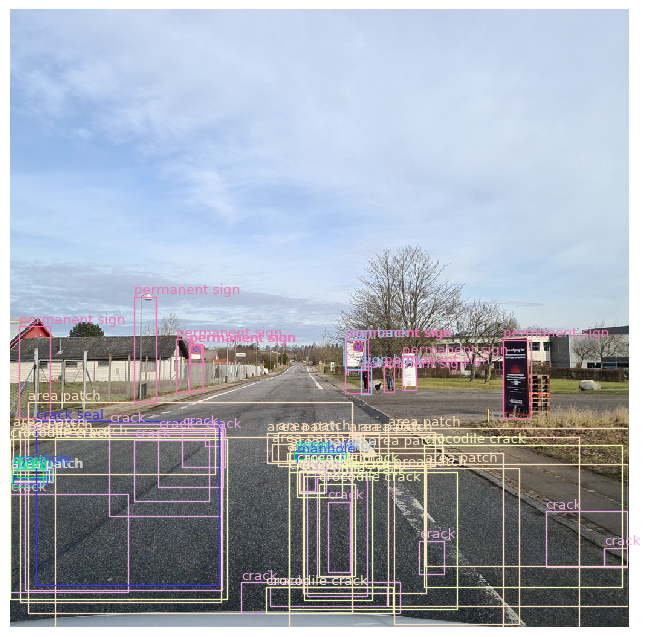

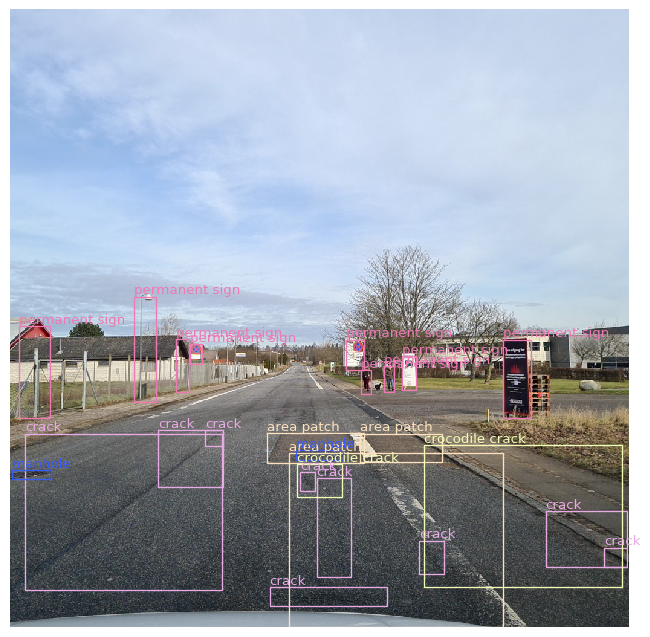

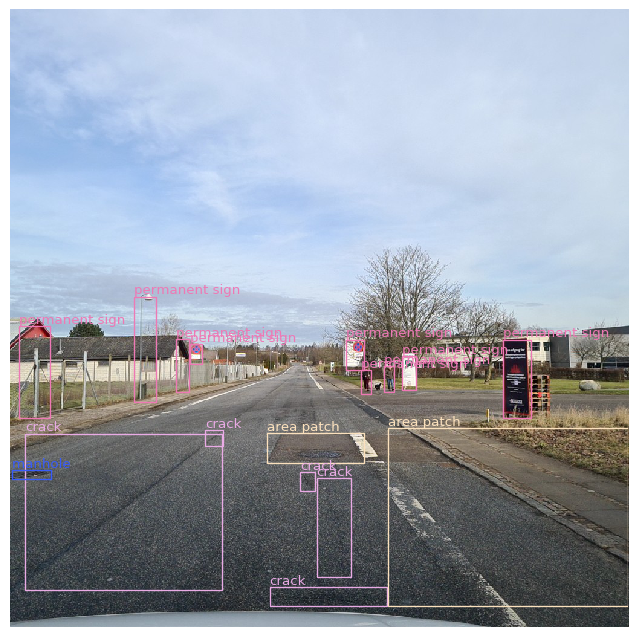

In [49]:
# pick one image from the test set
# The test sets are the images from Hylleholtvej, Strandvejen, and Bækvej
# TODO: A compatible loader for the test set 
from torchvision.ops.boxes import nms
from torch import index_select, masked_select

data_loader = torch.utils.data.DataLoader(
    dataset_no_random, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

count = -1
for imgs, target in tqdm(data_loader):
    count += 1
    if count != index: continue
    print(dataset_no_random._img_paths[0])

    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
    
    # Without non-maximum supression: 
    plot(imgs[0], prediction['boxes'].cpu(), prediction['labels'].cpu().numpy())
   
    # With 0.2 IoU based non-maximum supression applied
    indices = nms(prediction['boxes'], prediction['scores'], 0.2)
    plot(imgs[0], prediction['boxes'][indices].cpu(), prediction['labels'][indices].cpu().numpy())
     
    # With 0.01 IoU based non-maximum supression applied
    indices = nms(prediction['boxes'], prediction['scores'], 0.01)
    plot(imgs[0], prediction['boxes'][indices].cpu(), prediction['labels'][indices].cpu().numpy())
    
    # Groundtruth
    #plot(imgs[0], target[0]['boxes'], target[0]['labels'].cpu().numpy())
    break

### Generating model output without tracktor
Output is stored in Pascal VOC format and we're using [Object Detecting metrics](https://github.com/rafaelpadilla/review_object_detection_metrics) to evaluate the mAP scores. 

In [50]:
for imgs, target in tqdm(data_loader):
    model.eval()
    with torch.no_grad():
        prediction = model([imgs[0].to(device)])[0]
        
    # xyrb pascal VOC format:
    # <class_name> <confidence> <left> <top> <right> <bottom> 
    img_id = img_ids[target[0]['image_id']]
    with open(f"../../output/custom/faster_rcnn_fpn/testing/{img_id}.txt", 'w') as f:
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            x1, y1, x2, y2 = box.cpu().numpy()
            f.write(f"{class_index[str(label.item())]} {score} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n")

In [14]:
#del model # release
torch.cuda.empty_cache()

In [ ]:
dir_gts = '../../data/gt/'
dir_dets = '../../output/custom/faster_rcnn_fpn/testing/'
gt_bbs = converter.text2bb(dir_gts, bb_type=BBType.GROUND_TRUTH, bb_format=BBFormat.XYX2Y2)
det_bbs = converter.text2bb(dir_dets, bb_type=BBType.DETECTED, bb_format=BBFormat.XYX2Y2)

In [ ]:
ious = [0.01, 0.2, 0.5, 0.75]
voc_res = {}
for iou in ious:
    res = pascal_voc_evaluator.get_pascalvoc_metrics(gt_bbs, det_bbs, iou, generate_table=True, method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION)
    voc_res[iou], mAP = res['per_class'], res['mAP'] 
    #pascal_voc_evaluator.plot_precision_recall_curves(voc_res[iou], showInterpolatedPrecision=True, showAP=True)

    print(f"Mean average precision (mAP): {mAP} at IoU threshold {iou}")

### Model with Tracktor
Rerunning the experiment but now with Tracktor. 

> **Note**: Non of what the paper mentions as _extensions_ are applied

In [18]:
obj_detects = []
obj_detect_model = "../../output/custom/model_epoch_30.model"
obj_detect = FRCNN_FPN(num_classes=31)
obj_detect.load_state_dict(torch.load(obj_detect_model, map_location=lambda storage, loc: storage))
obj_detects.append(obj_detect)
obj_detect.eval()
obj_detect.cuda();

In [19]:
tracker_conf = {
  "detection_person_thresh": 0.5,
  "regression_person_thresh": 0.5,
  "detection_nms_thresh": 0.1,
  "regression_nms_thresh": 0.1,
  "motion_model" : {
    "enabled": True,
    "n_steps": 5,
    "center_only": True
  },
  "public_detections": False,
  "do_align": True,
  "warp_mode": "MOTION_EUCLIDEAN",
  "number_of_iterations": 100,
  "termination_eps": 0.00001,
  "do_reid": False,
  "inactive_patience": 50,
  "max_features_num": 10,
  "reid_sim_threshold": 2.0,
  "reid_iou_threshold": 0.2
}
tracker = Tracker(obj_detect, [], tracker_conf)
tracker.reset()
num_frames = 0

In [20]:
count = 0
for i, frame in enumerate(tqdm(data_loader, leave=True, position=0)):
    count += 1
    #if len(seq) * frame_split[0] <= i <= len(seq) * frame_split[1]:
    with torch.no_grad():
        tracker.step({'img': frame[0][0].unsqueeze(0)})
        num_frames += 1
    if count > 20: pass

results = tracker.get_results()
results = interpolate_tracks(results)
#seq.write_results(results)

KeyboardInterrupt: 

In [ ]:
from tracktor.utils import class_index

outdir = "../../output/custom/faster_rcnn_fpn/testing"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
    
for f in os.listdir(outdir):
    os.remove(os.path.join(outdir, f))

# xyrb pascal VOC format:
# <class_name> <confidence> <left> <top> <right> <bottom> 
for pred in results.values():
    for i, k in pred.items(): pass
    img_id = img_ids[i]
    with open(os.path.join(outdir, f"{img_id}.txt"), 'a+') as f:
        x1, y1, x2, y2, label_index, confidence = k
        f.write(f"{class_index[str(int(label_index))]} {confidence} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n")

        

In [ ]:
dir_gts = '../../data/gt/'
dir_dets = '../../output/custom/faster_rcnn_fpn/testing/'
gt_bbs = converter.text2bb(dir_gts, bb_type=BBType.GROUND_TRUTH, bb_format=BBFormat.XYX2Y2)
det_bbs = converter.text2bb(dir_dets, bb_type=BBType.DETECTED, bb_format=BBFormat.XYX2Y2)

ious = [0.01, 0.2, 0.5, 0.75]
voc_res = {}
for iou in ious:
    res = pascal_voc_evaluator.get_pascalvoc_metrics(gt_bbs, det_bbs, iou, generate_table=True, method=MethodAveragePrecision.EVERY_POINT_INTERPOLATION)
    voc_res[iou], mAP = res['per_class'], res['mAP'] 
    #pascal_voc_evaluator.plot_precision_recall_curves(voc_res[iou], showInterpolatedPrecision=True, showAP=True)

    print(f"Mean average precision (mAP): {mAP} at IoU threshold {iou}")